# Create a piecewise constant field for spatially varying properties

```{admonition} Objectives
:class: objectives

We provide here a utility function to create a piecewise constant field for each region of a domain
```

```{admonition} Download sources
:class: download

* {Download}`Python script<./piecewise_constant_field.py>`
* {Download}`Jupyter notebook<./piecewise_constant_field.ipynb>`
```

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
from dolfinx import mesh, fem


def create_piecewise_constant_field(domain, cell_markers, property_dict, name=None):
    """Create a piecewise constant field with different values per subdomain.

    Parameters
    ----------
    domain : Mesh
        `dolfinx` mesh object
    cell_markers : MeshTag
        cell marker MeshTag
    property_dict : dict
        A dictionary mapping region tags to physical values {tag: value}

    Returns
    -------
    A DG-0 function
    """
    V0 = fem.functionspace(domain, ("DG", 0))
    k = fem.Function(V0, name=name)
    for tag, value in property_dict.items():
        cells = cell_markers.find(tag)
        k.x.array[cells] = np.full_like(cells, value, dtype=np.float64)
    return k

For instance, we first create a square mesh and define a geometric marker marking a square strip of inner radius `a` and outer radius `b`:

In [157]:
N = 40
domain = mesh.create_unit_square(
    MPI.COMM_WORLD, N, N, cell_type=mesh.CellType.quadrilateral
)


def strip(x, a, b, eps=1e-8):
    return np.logical_and(
        np.logical_and(np.abs(x[0] - 0.5) <= b + eps, np.abs(x[1] - 0.5) <= b + eps),
        np.logical_or(np.abs(x[0] - 0.5) >= a - eps, np.abs(x[1] - 0.5) >= a - eps),
    )

We then use the function `mark_entities` introduced in [](/tips/mark_facets/mark_facets.md) to mark the corresponding cells and create a piecewise constant field.

In [158]:
def mark_entities(domain, dim, entities_dict):
    """Mark entities of specified dimension according to geometrical location

    Parameters
    ----------
    domain : Mesh
        `dolfinx` mesh object
    dim : int
        Dimension of the entities to mark
    entities_dict : dict
        A dictionary mapping integer tags with geometrical location function {tag: locator(x)}

    Returns
    -------
    entities_tag array
    """
    marked_values = []
    marked_entities = []
    # number of non-ghosted entities
    num_entities_local = domain.topology.index_map(dim).size_local
    # Concatenate and sort the arrays based on indices
    for tag, location in entities_dict.items():
        entities = mesh.locate_entities(domain, dim, location)
        entities = entities[entities < num_entities_local]  # remove ghost entities
        marked_entities.append(entities)
        marked_values.append(np.full_like(entities, tag))
    marked_entities = np.hstack(marked_entities)
    marked_values = np.hstack(marked_values)
    sorted_entities = np.argsort(marked_entities)
    entities_tags = mesh.meshtags(
        domain, dim, marked_entities[sorted_entities], marked_values[sorted_entities]
    )
    return entities_tags

In [185]:
tdim = domain.topology.dim
cell_markers = mark_entities(
    domain,
    tdim,
    {
        0: lambda x: strip(x, 0, 0.1),
        1: lambda x: strip(x, 0.1, 0.2),
        2: lambda x: strip(x, 0.2, 0.3),
        3: lambda x: strip(x, 0.3, 0.4),
        4: lambda x: strip(x, 0.4, 0.5),
    },
)
func = create_piecewise_constant_field(
    domain, cell_markers, {k: float(k) for k in range(5)}
)

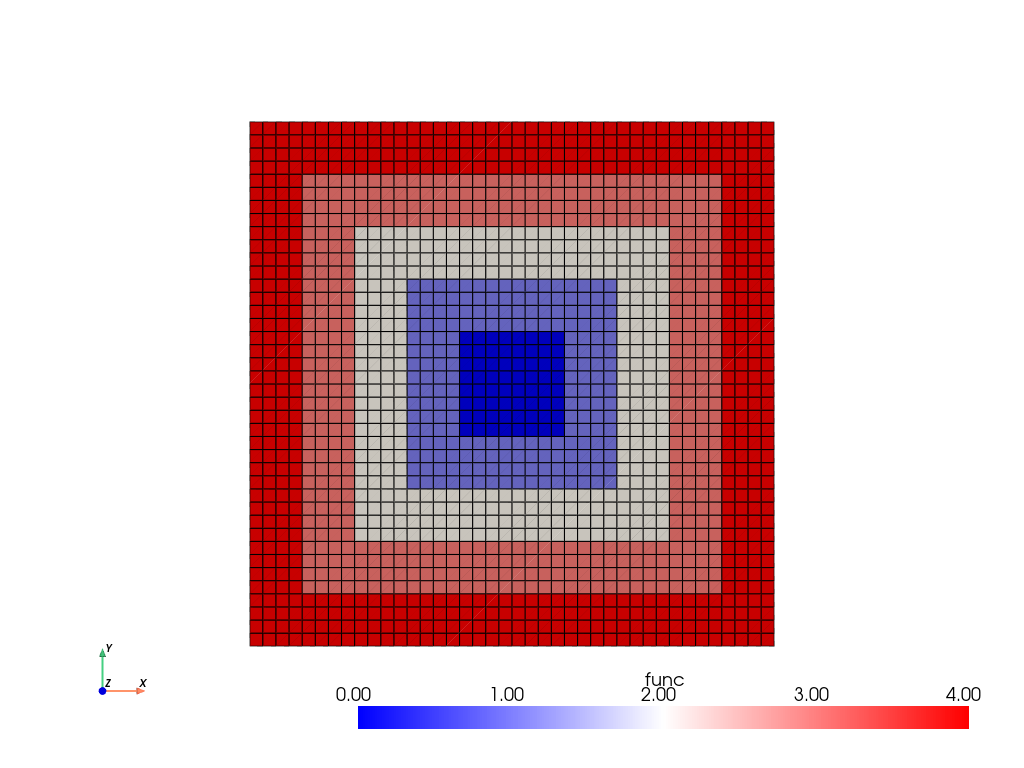

In [187]:
import pyvista
from dolfinx import plot

pyvista.set_jupyter_backend("static")

topology, cell_types, geometry = plot.vtk_mesh(domain, 2)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
grid.cell_data["func"] = func.x.array
grid.set_active_scalars("func")
# Create plotter and pyvista grid
p = pyvista.Plotter()
p.add_mesh(grid, show_edges=True, cmap="bwr")
p.view_xy()
p.show_axes()
p.show()